In [1]:
from visual_behavior_glm.src.glm import GLM
import visual_behavior_glm.src.GLM_fit_tools as gft
import visual_behavior_glm.src.GLM_analysis_tools as gat
import visual_behavior_glm.src.GLM_visualization_tools as gvt

import visual_behavior.utilities as vbu
import visual_behavior.plotting as vbp
import visual_behavior.data_access.loading as loading
import visual_behavior.visualization.utils as vis_utils
import visual_behavior.database as db

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import scikit_posthocs

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib inline
%widescreen

# Collect cached results from mongodb

In [3]:
glm_version = 3
conn = db.Database('visual_behavior_data')
database = 'ophys_glm'
results_full = pd.DataFrame(list(conn[database]['results_full'].find({'glm_version':glm_version})))
results_summary = pd.DataFrame(list(conn[database]['results_summary'].find({'glm_version':glm_version})))

In [4]:
len(results_full)

34033

# get the experiments table

In [5]:
experiments_table = loading.get_filtered_ophys_experiment_table()
len(experiments_table)

1464

# basic exploration

In [6]:
experiments_table['targeted_structure'].value_counts()

VISp     818
VISl     469
VISam     91
VISal     86
Name: targeted_structure, dtype: int64

In [7]:
experiments_table['cre_line'].value_counts()

Slc17a7-IRES2-Cre    688
Vip-IRES-Cre         519
Sst-IRES-Cre         257
Name: cre_line, dtype: int64

## apply a threshold on variance explained (assign to a boolean column called `above_CV_threshold`)

In [8]:
results_full['above_CV_threshold'] = results_full['Full_avg_cv_var_test'].map(lambda CV: CV>=0.01)

In [9]:
results_summary = results_summary.merge(
    results_full[['ophys_experiment_id','cell_specimen_id','above_CV_threshold']],
    left_on = ['ophys_experiment_id','cell_specimen_id'],
    right_on = ['ophys_experiment_id','cell_specimen_id'],
    how='left'
)

In [10]:
results_summary.sample(5)

,_id,dropout,variance_explained,fraction_change_from_full,absolute_change_from_full,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,entry_time_utc,glm_version,above_CV_threshold
401358,5ee8bcf4aa1f8f6238500142,image4,-0.006261,0.169536,-0.000908,962642153,806455766,806203732,806296598,803589437,VisualBehavior,container_qc,passed,20190109_425496_1_images_A,OPHYS_1_images_A,CAM2P.4,2019-01-09 21:43:56.000000,781470340,772622653,M,106.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,772622653,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,2020-06-18 08:05:19.880109,3,False
370387,5ee8a775d6f2fb25221c1029,model_task0,-0.013290,0.002392,-0.000032,962551891,899085531,898870044,898982250,895259496,VisualBehaviorTask1B,container_qc,passed,20190702_461946_1imagesB,OPHYS_1_images_B,CAM2P.5,2019-07-02 16:39:24.000000,872873989,862671211,F,105.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,862671211,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,2020-06-18 06:02:22.359523,3,False
237661,5ee8692f6835e94dbfbf478a,intercept,0.000382,0.007052,0.000003,1028835864,945586425,944888114,945033994,1022731524,VisualBehaviorMultiscope,completed,passed,20190912_453991_Ophys3_retake_1,OPHYS_3_images_A,MESO.1,2019-09-12 11:25:18.650383,853117343,843401308,M,216.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],75,VISp,NaN,843401308,Vip-IRES-Cre,NaN,NaN,0,1,Vip_VISp_75,2020-06-18 03:50:04.604299,3,False
230757,5ee8689886bc2ef462aa7bf2,change,-0.010326,-0.021379,0.000226,1018097517,882551939,882060185,882256127,1018028364,VisualBehaviorMultiscope,completed,passed,20190606_435431_Ophys3,OPHYS_3_images_A,MESO.1,2019-06-06 09:29:08.939495,815343876,807248992,M,202.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],71,VISp,NaN,807248992,Vip-IRES-Cre,NaN,NaN,0,1,Vip_VISp_71,2020-06-18 03:15:31.870847,3,False
331813,5ee897d9e5f15b375516b2e8,post_licks,0.130470,-0.021280,-0.002837,1028834296,921024187,920695792,920839478,1018028172,VisualBehaviorMultiscope,completed,passed,20190809_453990_Ophys4,OPHYS_4_images_B,MESO.1,2019-08-09 12:55:56.000000,852262774,840544752,M,182.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],229,VISp,NaN,840544752,Vip-IRES-Cre,NaN,NaN,0,1,Vip_VISp_229,2020-06-18 05:10:17.162565,3,True


In [11]:
len(results_full['ophys_experiment_id'].unique())

609

In [12]:
len(results_summary['ophys_experiment_id'].unique())

609

In [13]:
results_summary.sample(5)

,_id,dropout,variance_explained,fraction_change_from_full,absolute_change_from_full,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,entry_time_utc,glm_version,above_CV_threshold
181193,5ee8651443e332ac806ad1dd,model_timing1D,-0.005539,-0.008370,0.000047,1028775327,885146779,884613038,884808160,1018027549,VisualBehaviorMultiscope,completed,passed,20190611_451787_4imagesB,OPHYS_4_images_B,MESO.1,2019-06-11 11:43:04.000000,846136902,837581585,M,132.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",221,VISp,NaN,837581585,Slc17a7-IRES2-Cre,NaN,NaN,2,1,Slc17a7_VISp_221,2020-06-18 02:20:47.504942,3,False
5853,5ee85f744f1efa5a039e3623,model_task0,0.288818,0.000560,0.000162,1028819143,958527477,954954402,953982960,1018028348,VisualBehaviorMultiscope,completed,passed,20190924_457841_3imagesA,OPHYS_3_images_A,MESO.1,2019-09-24 16:00:00.000000,858992726,850862430,F,210.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],300,VISp,NaN,850862430,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_300,2020-06-18 00:32:07.822267,3,True
90381,5ee8610d5e82458baf47855d,rewards,0.000903,-0.072591,-0.000071,1018094656,882551937,882060185,882256127,1018028374,VisualBehaviorMultiscope,completed,passed,20190606_435431_Ophys3,OPHYS_3_images_A,MESO.1,2019-06-06 09:29:08.939495,815343876,807248992,M,202.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],270,VISp,NaN,807248992,Vip-IRES-Cre,NaN,NaN,0,1,Vip_VISp_270,2020-06-18 00:49:13.206482,3,False
304466,5ee8911e714b862205989dcd,image3,0.009563,-0.262990,-0.003412,1018080166,977978329,977760370,977870164,1018028212,VisualBehaviorMultiscope,holding,passed,20191106_482853_Ophys3,OPHYS_3_images_A,MESO.1,2019-11-06 13:51:22.067175,937755139,925216111,M,129.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],150,VISl,NaN,925216111,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISl_150,2020-06-18 04:51:04.359036,3,True
276472,5ee88b52fa6474f0d7a047a1,image0,-0.000177,-0.389683,0.000113,1028810747,974994101,974486549,974634733,1018027834,VisualBehaviorMultiscope,completed,passed,20191031_484627_Ophys6,OPHYS_6_images_B,MESO.1,2019-10-31 08:26:06.328780,943395690,930825455,M,115.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",83,VISl,NaN,930825455,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISl_83,2020-06-18 03:50:15.060860,3,False


## organize some things

In [14]:
results_summary.dropout.unique()

array(['Full', 'intercept', 'time', 'pre_licks', 'post_licks', 'rewards',
       'change', 'omissions', 'running', 'pupil', 'image0', 'image1',
       'image2', 'image3', 'image4', 'image5', 'image6', 'image7',
       'model_bias', 'model_task0', 'model_omissions1', 'model_timing1D',
       'all-images', 'visual', 'beh_model', 'image_expectation',
       'pre_lick_bouts', 'post_lick_bouts'], dtype=object)

### for clarity, exclude the individual image kernels from plots

In [16]:
kernels_to_exclude = [k for k in results_summary.dropout.unique() if k.startswith('image')]
kernels_to_exclude = []

## clip the variance explained at reasonable limits. Can be either +/- 1 or -1 to 0

In [17]:
results_summary['clipped_fraction_change'] = results_summary['fraction_change_from_full'].map(lambda f:np.clip(f,-1,1))
results_summary['clipped_fraction_change_negative_only'] = results_summary['fraction_change_from_full'].map(lambda f:np.clip(f,-1,0))

In [18]:
fraction_change_order = results_summary.query('above_CV_threshold').groupby('dropout')['clipped_fraction_change'].mean().sort_values(ascending=False).index
fraction_change_order_negative_only = results_summary.query('above_CV_threshold').groupby('dropout')['clipped_fraction_change_negative_only'].mean().sort_values(ascending=False).index

In [19]:
fraction_change_order_limited = [k for k in fraction_change_order if k not in kernels_to_exclude]
fraction_change_order_negative_only_limited = [k for k in fraction_change_order_negative_only if k not in kernels_to_exclude]

## start making some plots!

In [20]:
genotype_order = ['Slc17a7-IRES2-Cre', 'Vip-IRES-Cre', 'Sst-IRES-Cre']

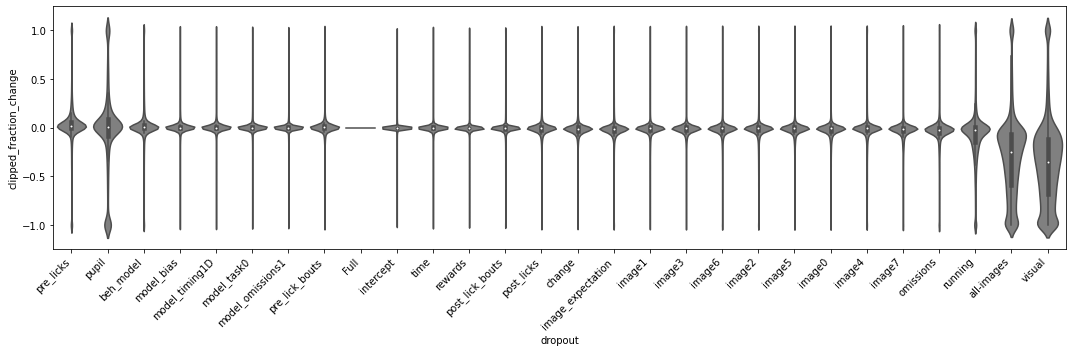

In [21]:
fig,ax=plt.subplots(figsize=(15,5))
vp = sns.violinplot(
    data = results_summary.query('dropout not in @kernels_to_exclude'),
    x = 'dropout',
    y = 'clipped_fraction_change',
    order=fraction_change_order_limited,
    scale='width',
    ax=ax,
    color='gray'
)
vp.set_xticklabels(labels=fraction_change_order_limited, rotation=45, ha='right')
fig.tight_layout()

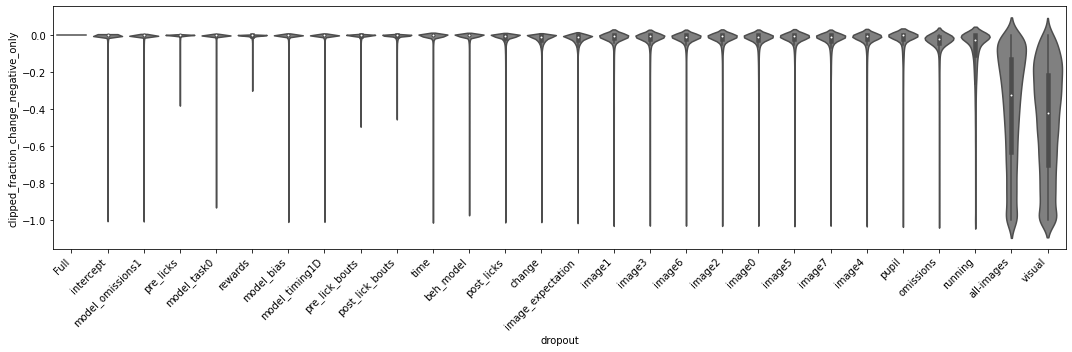

In [22]:
fig,ax=plt.subplots(figsize=(15,5))
vp = sns.violinplot(
    data = results_summary.query('above_CV_threshold'),
    x = 'dropout',
    y = 'clipped_fraction_change_negative_only',
    order=fraction_change_order_negative_only_limited,
    scale='width',
    ax=ax,
    color='gray'
)
vp.set_xticklabels(labels=fraction_change_order_negative_only_limited, rotation=45, ha='right')
fig.tight_layout()

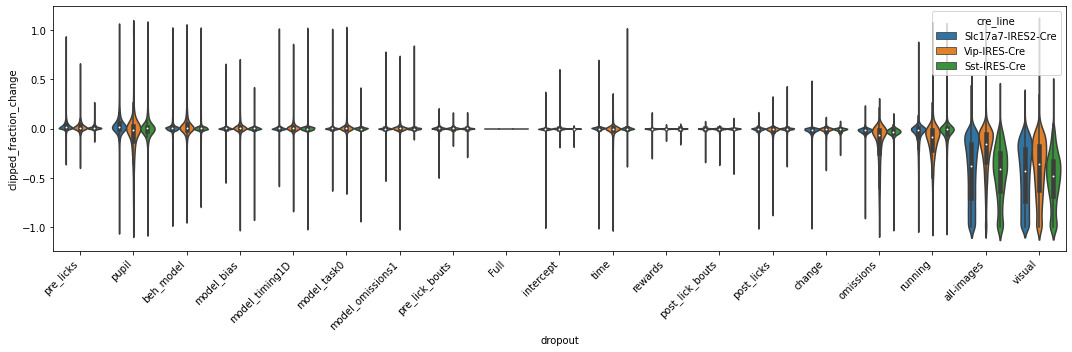

In [22]:
fig,ax=plt.subplots(figsize=(15,5))
vp = sns.violinplot(
    data = results_summary.query('dropout not in @kernels_to_exclude and above_CV_threshold'),
    x = 'dropout',
    y = 'clipped_fraction_change',
    order=fraction_change_order_limited,
    hue='cre_line',
    scale='width',
    ax=ax
)
vp.set_xticklabels(labels=fraction_change_order_limited, rotation=45, ha='right')
fig.tight_layout()

In [23]:
results_full['above_CV_threshold'].value_counts()

True     23092
False    10941
Name: above_CV_threshold, dtype: int64

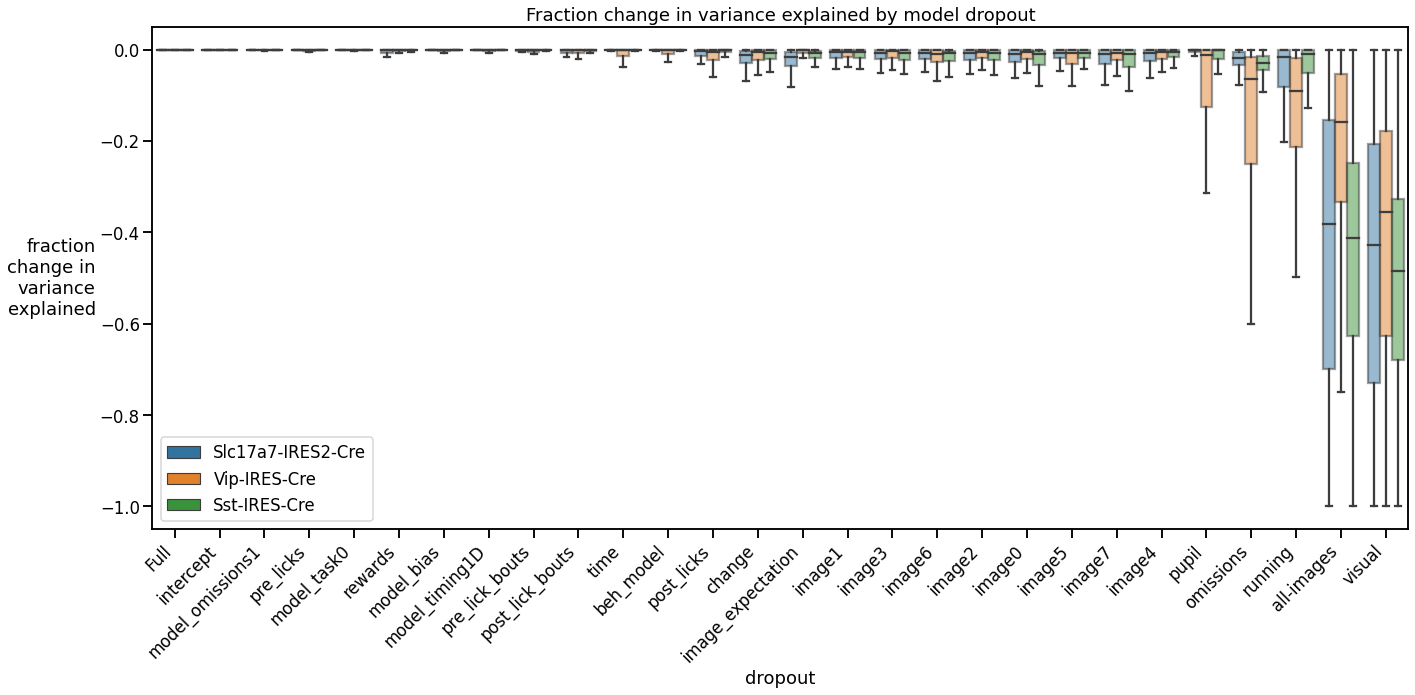

In [25]:
fig,ax=plt.subplots(figsize=(20,10))
show_dots = False

sns.set_context('talk')
if show_dots:
    sp = sns.stripplot(
        data = results_summary.query('dropout not in @kernels_to_exclude'),
        x = 'dropout',
        y = 'clipped_fraction_change_negative_only',
        order=fraction_change_order_negative_only_limited,
        hue='cre_line',
        hue_order=genotype_order,
        ax=ax,
        dodge=True,
        alpha=0.2
    )
bp = sns.boxplot(
    data = results_summary.query('dropout not in @kernels_to_exclude and above_CV_threshold'),
    x = 'dropout',
    y = 'clipped_fraction_change_negative_only',
    order=fraction_change_order_negative_only_limited,
    hue='cre_line',
    hue_order=genotype_order,
    ax=ax,
    fliersize=0,
    boxprops=dict(alpha=.5)
)
bp.legend(loc='lower left')
bp.set_xticklabels(labels=fraction_change_order_negative_only_limited, rotation=45, ha='right')
bp.set_ylabel('fraction\nchange in\nvariance\nexplained',rotation=0, ha='right',va='center')
ax.set_title('Fraction change in variance explained by model dropout')

fig.tight_layout()

In [26]:
results_summary.query('dropout not in @kernels_to_exclude and above_CV_threshold')

,_id,dropout,variance_explained,fraction_change_from_full,absolute_change_from_full,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,entry_time_utc,glm_version,above_CV_threshold,clipped_fraction_change,clipped_fraction_change_negative_only
0,5ee82c72275128047b0d93d9,Full,0.042141,0.000000,0.000000,962557462,833629926,833002992,833100683,829561794,VisualBehavior,container_qc,passed,20190306_431252_3imageA,OPHYS_3_images_A,CAM2P.4,2019-03-06 18:02:49.000000,792314934,784057626,F,139.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,784057626,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,2020-06-18 02:43:21.089067,3,True,0.000000,0.000000
1,5ee82c72275128047b0d93da,intercept,0.040386,-0.041648,-0.001755,962557462,833629926,833002992,833100683,829561794,VisualBehavior,container_qc,passed,20190306_431252_3imageA,OPHYS_3_images_A,CAM2P.4,2019-03-06 18:02:49.000000,792314934,784057626,F,139.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,784057626,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,2020-06-18 02:43:21.092219,3,True,-0.041648,-0.041648
2,5ee82c72275128047b0d93db,time,0.021904,-0.480235,-0.020238,962557462,833629926,833002992,833100683,829561794,VisualBehavior,container_qc,passed,20190306_431252_3imageA,OPHYS_3_images_A,CAM2P.4,2019-03-06 18:02:49.000000,792314934,784057626,F,139.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,784057626,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,2020-06-18 02:43:21.107552,3,True,-0.480235,-0.480235
3,5ee82c72275128047b0d93dc,pre_licks,0.043540,0.033196,0.001399,962557462,833629926,833002992,833100683,829561794,VisualBehavior,container_qc,passed,20190306_431252_3imageA,OPHYS_3_images_A,CAM2P.4,2019-03-06 18:02:49.000000,792314934,784057626,F,139.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,784057626,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,2020-06-18 02:43:21.110038,3,True,0.033196,0.000000
4,5ee82c72275128047b0d93dd,post_licks,0.043550,0.033417,0.001408,962557462,833629926,833002992,833100683,829561794,VisualBehavior,container_qc,passed,20190306_431252_3imageA,OPHYS_3_images_A,CAM2P.4,2019-03-06 18:02:49.000000,792314934,784057626,F,139.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,784057626,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,2020-06-18 02:43:21.117229,3,True,0.033417,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461855,5eeb270bb47c1c1bf89c378a,post_lick_bouts,0.055873,0.001678,0.000094,962620027,795948257,795866393,795903435,814796558,VisualBehavior,container_qc,passed,20181214_416369_2P5_VISp_375_3,OPHYS_3_images_A,CAM2P.5,2018-12-15 00:07:47.000000,761346702,756577249,F,130.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,756577249,Slc17a7-IRES2-Cre,NaN,NaN,3,1,Slc17a7_VISp_375,2020-06-18 08:34:19.070691,3,True,0.001678,0.000000
461856,5eeb270fb47c1c1bf89c378b,image_expectation,0.053616,-0.038768,-0.002162,962620027,795948257,795866393,795903435,814796558,VisualBehavior,container_qc,passed,20181214_416369_2P5_VISp_375_3,OPHYS_3_images_A,CAM2P.5,2018-12-15 00:07:47.000000,761346702,756577249,F

## just a little stats exploration

In [27]:
scikit_posthocs.posthoc_mannwhitney(
    results_summary.query('dropout == "visual" and above_CV_threshold'),
    val_col='clipped_fraction_change_negative_only',
    group_col='cre_line',
    p_adjust='bonferroni'
)

,Slc17a7-IRES2-Cre,Sst-IRES-Cre,Vip-IRES-Cre
Slc17a7-IRES2-Cre,-1.000000e+00,4.680966e-09,1.293761e-12
Sst-IRES-Cre,4.680966e-09,-1.000000e+00,1.384005e-27
Vip-IRES-Cre,1.293761e-12,1.384005e-27,-1.000000e+00


In [28]:
scikit_posthocs.posthoc_mannwhitney(
    results_summary.query('dropout == "intercept" and above_CV_threshold'),
    val_col='clipped_fraction_change_negative_only',
    group_col='cre_line',
    p_adjust='bonferroni'
)

,Slc17a7-IRES2-Cre,Sst-IRES-Cre,Vip-IRES-Cre
Slc17a7-IRES2-Cre,-1.000000,0.096931,0.024383
Sst-IRES-Cre,0.096931,-1.000000,0.000376
Vip-IRES-Cre,0.024383,0.000376,-1.000000


In [29]:
scikit_posthocs.posthoc_mannwhitney(
    results_summary.query('dropout == "running" and above_CV_threshold'),
    val_col='clipped_fraction_change_negative_only',
    group_col='cre_line',
#     p_adjust='bonferroni'
)

,Slc17a7-IRES2-Cre,Sst-IRES-Cre,Vip-IRES-Cre
Slc17a7-IRES2-Cre,-1.000000e+00,4.849938e-07,5.315849e-133
Sst-IRES-Cre,4.849938e-07,-1.000000e+00,1.157118e-97
Vip-IRES-Cre,5.315849e-133,1.157118e-97,-1.000000e+00


,count,mean,std,min,25%,50%,75%,max
cre_line,,,,,,,,
Slc17a7-IRES2-Cre,7061.0,-0.028214,0.052379,-0.890556,-0.034609,-0.017783,-0.006443,0.0
Sst-IRES-Cre,1367.0,-0.037889,0.065097,-1.000000,-0.045609,-0.030513,-0.013513,0.0
Vip-IRES-Cre,2249.0,-0.173139,0.226412,-1.000000,-0.249709,-0.064389,-0.015549,0.0


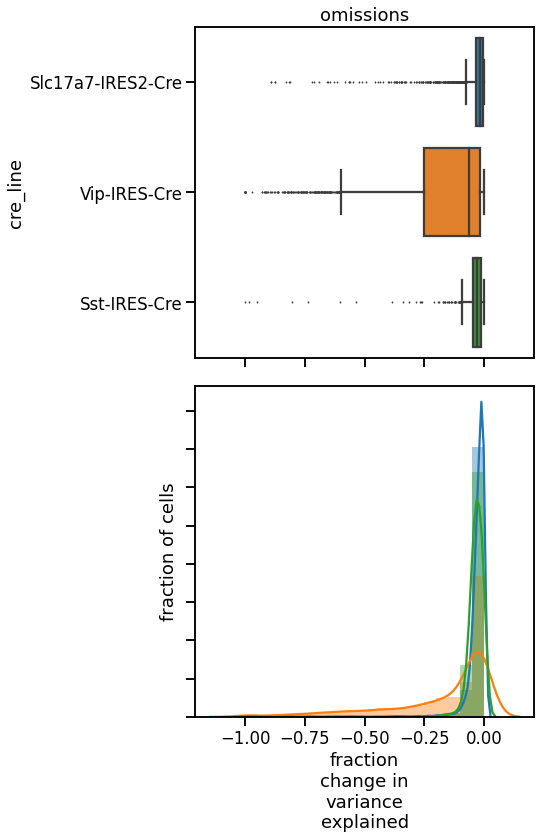

In [30]:
fig,ax=plt.subplots(2,1,figsize=(8,12), sharex=True)
dropout = 'omissions'

data_to_plot = results_summary.query("dropout == '{}' and above_CV_threshold".format(dropout))
sns.boxplot(
    data=data_to_plot,
    x='clipped_fraction_change_negative_only',
    y='cre_line',
    order=genotype_order,
    ax=ax[0],
    fliersize=1
)
    
for cre_line in genotype_order:
    data_to_plot = results_summary.query("dropout == '{}' and cre_line == '{}' and above_CV_threshold".format(dropout, cre_line))

    sns.distplot(
        data_to_plot['clipped_fraction_change_negative_only'],
        ax=ax[1],
        norm_hist=True,
        bins=np.arange(-1,0.05,0.05),
    )
ax[0].set_title(dropout)
ax[0].set_xlabel('')
ax[1].set_yticklabels([])
ax[1].set_ylabel('fraction of cells')
ax[1].set_xlabel('fraction\nchange in\nvariance\nexplained')
fig.tight_layout()
results_summary.query("dropout == '{}' and above_CV_threshold".format(dropout)).groupby('cre_line')['clipped_fraction_change_negative_only'].describe()


/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/seaborn-0.10.1-py3.8.egg/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/seaborn-0.10.1-py3.8.egg/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/seaborn-0.10.1-py3.8.egg/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


IndexError: index 24 is out of bounds for axis 0 with size 24

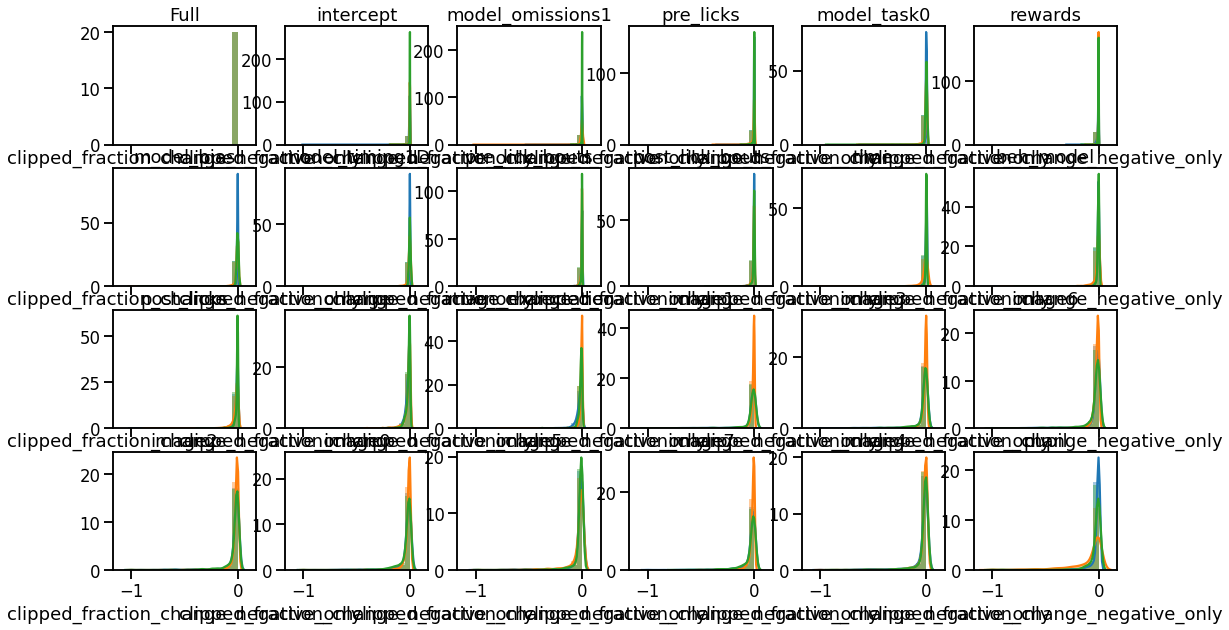

In [31]:
fig,ax=plt.subplots(4,6,figsize=(18,10),sharex=True, sharey=False)
for ii,dropout in enumerate(fraction_change_order_negative_only_limited):
    for cre_line in genotype_order:
        data_to_plot = results_summary.query("dropout == '{}' and cre_line == '{}' and above_CV_threshold".format(dropout, cre_line))
        sns.distplot(
            data_to_plot['clipped_fraction_change_negative_only'],
            ax=ax.flatten()[ii],
            norm_hist=True,
            bins=np.arange(-1,0.1,0.05),
        )
    ax.flatten()[ii].set_title(dropout)
sns.despine()
fig.tight_layout()

## split by imaging depth. But how?

In [32]:
results_summary['imaging_depth'].unique()

array([375, 175,  75, 300, 225, 150, 371,  81, 373, 377, 167,  83, 269,
        77,  85,  73, 165, 363,  79, 359,  67, 367, 279, 379,  69, 171,
       169, 361, 259, 181, 282, 271, 275, 267, 276, 302, 284, 274, 263,
       221, 298, 146,  71, 223, 219, 148, 270, 215, 154, 218, 312, 156,
       144, 227, 229, 308, 152, 217, 365, 273, 381, 261, 290, 292, 283,
       277, 355, 183,  95, 291, 369, 281, 179, 173, 310,  70, 320, 285,
       145, 321,  76, 149, 287, 228, 286, 316, 132, 294, 296, 350,  65,
       352])

### choose some arbitrary thresholds on image depth. I'm sure there's a better way, but good for now

(0.0, 0.03)

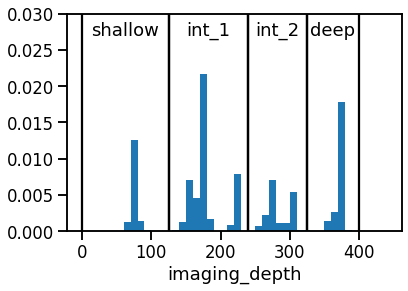

In [33]:
fig,ax=plt.subplots()
ax.hist(results_summary['imaging_depth'],bins=np.arange(0,450,10),density=True)
ax.set_xlabel('imaging_depth')
groups_by_depth = {
    'shallow':(0,125),
    'int_1':(125,240),
    'int_2':(240,325),
    'deep':(325,400)
}
for name,boundaries in groups_by_depth.items():
    ax.axvline(boundaries[0],color='black')
    ax.axvline(boundaries[1],color='black')
    
    ax.text(boundaries[0] + (boundaries[1] - boundaries[0])/2, 0.027, name, ha='center')
ax.set_ylim(0,0.03)

In [34]:
def assign_depth_category(depth,groups_by_depth):
    for name,boundaries in groups_by_depth.items():
        if depth > boundaries[0] and depth < boundaries[1]:
            return name
        
experiments_table['depth_bin'] = experiments_table['imaging_depth'].map(lambda depth:assign_depth_category(depth, groups_by_depth))
results_summary = results_summary.merge(
    experiments_table.reset_index()[['ophys_experiment_id','depth_bin']],
    left_on = 'ophys_experiment_id',
    right_on = 'ophys_experiment_id',
    how='left'
)

In [35]:
results_summary[['ophys_experiment_id','targeted_structure','depth_bin']].drop_duplicates().groupby('targeted_structure')['depth_bin'].value_counts()

targeted_structure  depth_bin
VISl                int_1         84
                    int_2         59
                    shallow       50
                    deep          19
VISp                int_1        169
                    int_2         93
                    deep          81
                    shallow       54
Name: depth_bin, dtype: int64

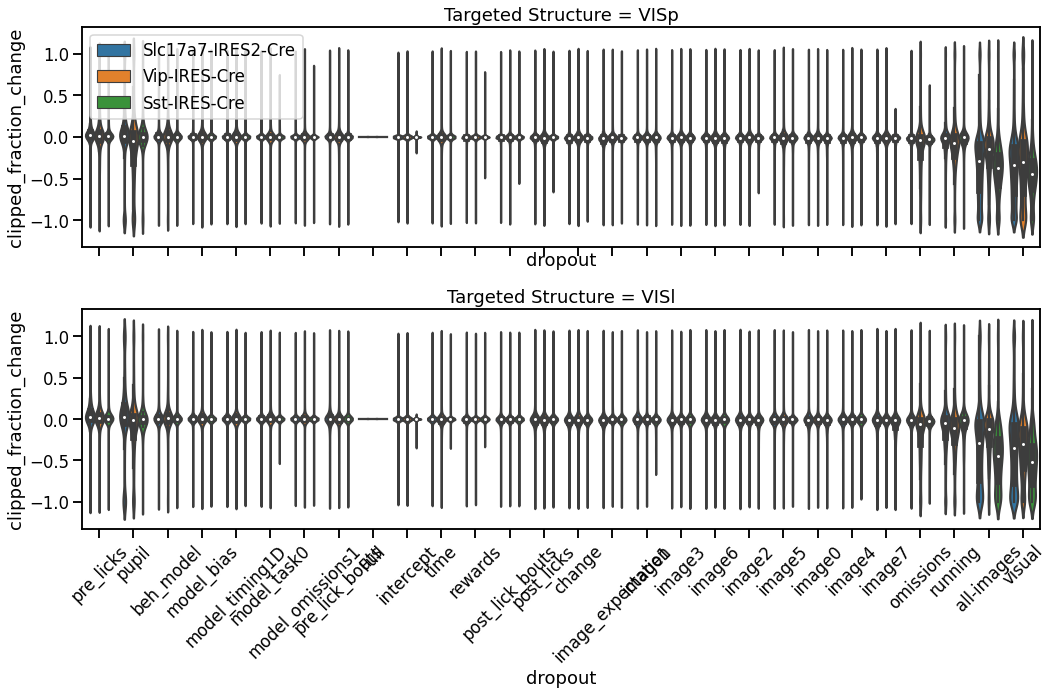

In [36]:
fig,ax=plt.subplots(2,1,figsize=(15,10),sharex=True)
row = 0
for _,structure in enumerate(['VISp','VISl']):
    results_to_plot = results_summary.query('targeted_structure == @structure')

    vp = sns.violinplot(
        data = results_to_plot,
        x = 'dropout',
        y = 'clipped_fraction_change',
        order=fraction_change_order,
        hue='cre_line',
        hue_order = genotype_order,
        scale='width',
        ax=ax[row],
    )
    ax[row].set_title('Targeted Structure = {}'.format(structure))
    if row != 0:
        vp.legend_.remove()
    else:
        vp.legend(loc='upper left')
    row += 1
    
vp.set_xticklabels(labels=fraction_change_order, rotation=45)
fig.tight_layout()

## split by both structure and depth!!

<ipython-input-37-53ab9ad983b8>:25: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


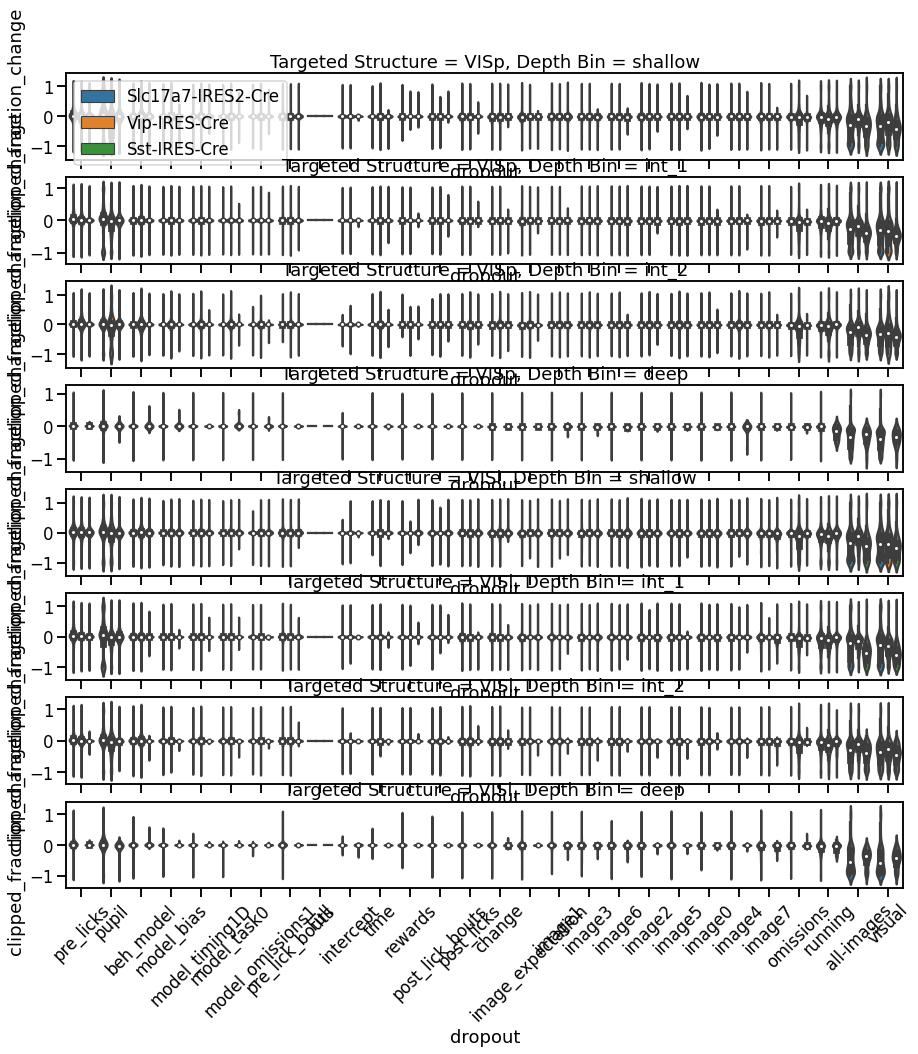

In [37]:
fig,ax=plt.subplots(8,1,figsize=(15,15),sharex=True)
row = 0
for _,structure in enumerate(['VISp','VISl']):
    for _, depth in enumerate(['shallow','int_1','int_2','deep']):
        results_to_plot = results_summary.query('targeted_structure == @structure and depth_bin == @depth')
        
        vp = sns.violinplot(
            data = results_to_plot,
            x = 'dropout',
            y = 'clipped_fraction_change',
            order=fraction_change_order,
            hue='cre_line',
            hue_order=genotype_order,
            scale='width',
            ax=ax[row],
        )
        ax[row].set_title('Targeted Structure = {}, Depth Bin = {}'.format(structure, depth))
        if row != 0:
            vp.legend_.remove()
        else:
            vp.legend(loc='upper left')
        row += 1
    
vp.set_xticklabels(labels=fraction_change_order, rotation=45)
fig.tight_layout()

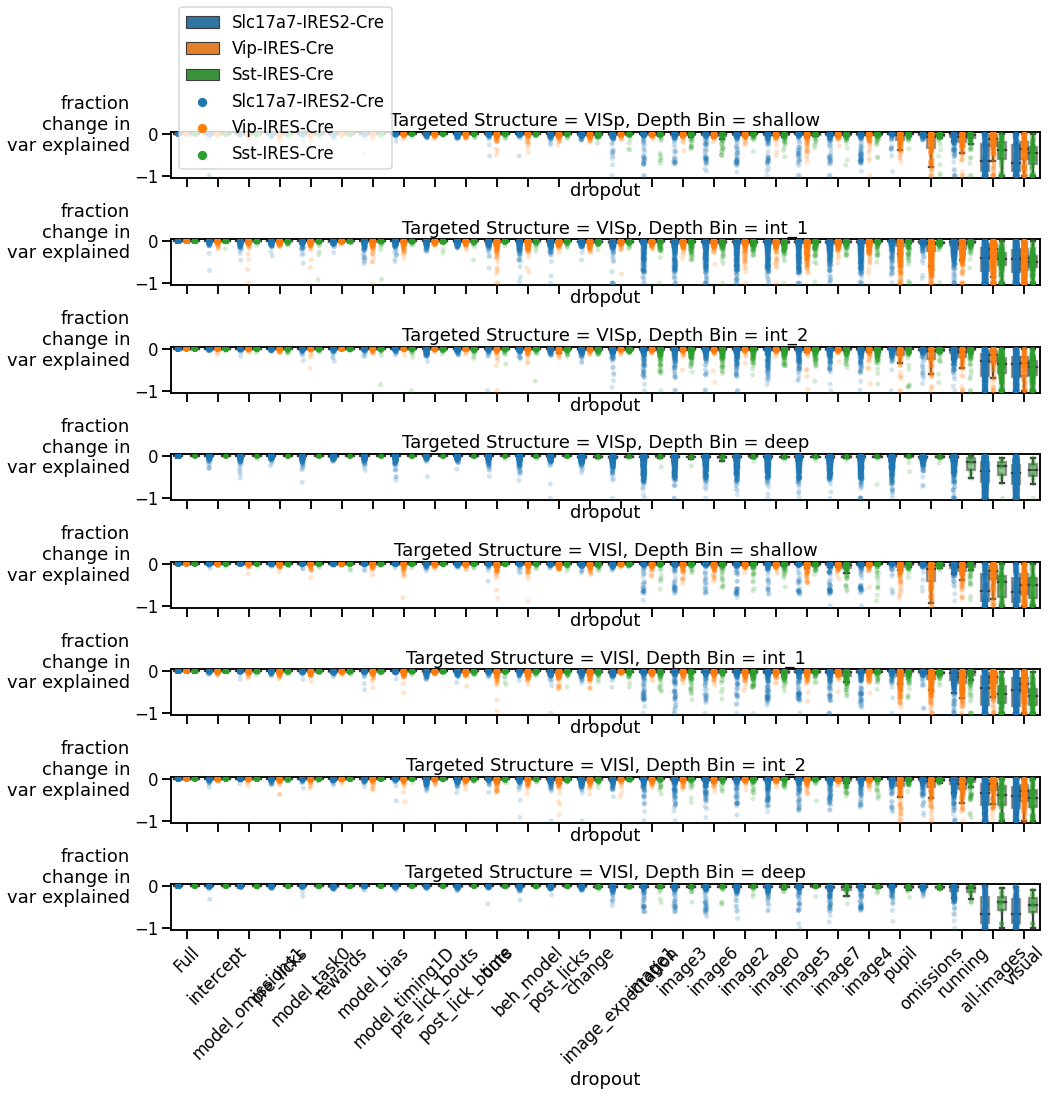

In [38]:
fig,ax=plt.subplots(8,1,figsize=(15,15),sharex=True)
row = 0
for _,structure in enumerate(['VISp','VISl']):
    for _, depth in enumerate(['shallow','int_1','int_2','deep']):
        
        bp = sns.boxplot(
            data = results_summary.query('targeted_structure == @structure and depth_bin == @depth and dropout not in @kernels_to_exclude and above_CV_threshold'),
            x = 'dropout',
            y = 'clipped_fraction_change_negative_only',
            order=fraction_change_order_negative_only_limited,
            hue='cre_line',
            hue_order=genotype_order,
            ax=ax[row],
            fliersize=0,
            boxprops=dict(alpha=.5)
        )

        sp = sns.stripplot(
            data = results_summary.query('targeted_structure == @structure and depth_bin == @depth and dropout not in @kernels_to_exclude and above_CV_threshold'),
            x = 'dropout',
            y = 'clipped_fraction_change_negative_only',
            order=fraction_change_order_negative_only_limited,
            hue='cre_line',
            hue_order=genotype_order,
            ax=ax[row],
            dodge=True,
            alpha=0.2
        )
#         sp.legend(loc='lower left')
        sp.set_xticklabels(labels=fraction_change_order_negative_only_limited, rotation=45)
        ax[row].set_title('Targeted Structure = {}, Depth Bin = {}'.format(structure, depth))
        ax[row].set_ylabel('fraction\nchange in\nvar explained',rotation=0,ha='right')
        
        if row != 0:
            sp.legend_.remove()
        else:
            sp.legend(loc='lower left')
        row += 1

fig.tight_layout()

## look at the distribution of variance explained for all cells by cre line

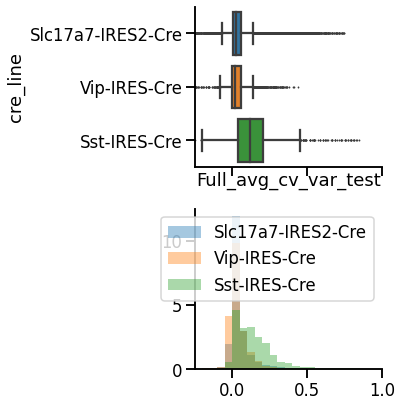

In [39]:
fig,ax=plt.subplots(2,1,figsize=(6,6),sharex=True)
for cre_line in genotype_order:
    data_to_plot = results_full.query("cre_line == '{}'".format(cre_line))
    sns.distplot(
        data_to_plot['Full_avg_cv_var_test'],
        ax=ax[1],
        norm_hist=True,
        bins=np.arange(-1,1,0.05),
        kde=False,
    )
sns.boxplot(
    data = results_full,
    x = 'Full_avg_cv_var_test',
    y = 'cre_line',
    order = genotype_order,
    fliersize=1,
    ax=ax[0]
)
ax[1].legend(genotype_order)
sns.despine()
ax[0].set_xlim(-0.25,1)
ax[1].set_xlabel('variance explained by full model')
ax[1].set_xlabel('')
fig.tight_layout()

In [40]:
results_full.groupby('cre_line')['above_CV_threshold'].value_counts()

cre_line           above_CV_threshold
Slc17a7-IRES2-Cre  True                  19428
                   False                  9099
Sst-IRES-Cre       True                   1367
                   False                   164
Vip-IRES-Cre       True                   2297
                   False                  1678
Name: above_CV_threshold, dtype: int64

In [41]:
results_full.groupby('cre_line')['above_CV_threshold'].value_counts(normalize=True)

cre_line           above_CV_threshold
Slc17a7-IRES2-Cre  True                  0.681039
                   False                 0.318961
Sst-IRES-Cre       True                  0.892880
                   False                 0.107120
Vip-IRES-Cre       True                  0.577862
                   False                 0.422138
Name: above_CV_threshold, dtype: float64

In [42]:
results_summary.sample(5)

,_id,dropout,variance_explained,fraction_change_from_full,absolute_change_from_full,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,entry_time_utc,glm_version,above_CV_threshold,clipped_fraction_change,clipped_fraction_change_negative_only,depth_bin
431083,5eeabf23c4b9570df9beb886,pre_lick_bouts,0.039356,-0.022467,-0.000905,1007033062,968651977,967965969,968334595,957570596,VisualBehaviorTask1B,container_qc,passed,20191016_467953_4imagesA,OPHYS_4_images_A,CAM2P.4,2019-10-16 15:28:20.000000,888943558,880255046,M,183.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],175,VISp,NaN,880255046,Vip-IRES-Cre,NaN,NaN,0,1,Vip_VISp_175,2020-06-18 01:10:46.424586,3,True,-0.022467,-0.022467,int_1
64631,5ee8606a4fed494be4df4491,change,0.022226,0.002369,0.000053,1028839633,942596359,941676716,941802699,1022731547,VisualBehaviorMultiscope,completed,passed,20190909_453991_Ophys1_retake_1,OPHYS_1_images_A,MESO.1,2019-09-09 12:29:05.000000,853117343,843401308,M,213.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],300,VISl,NaN,843401308,Vip-IRES-Cre,NaN,NaN,1,1,Vip_VISl_300,2020-06-18 00:48:51.506438,3,True,0.002369,0.000000,int_2
400907,5ee8bcc809bdee1244dd5704,intercept,0.032229,0.023222,0.000731,962558833,848697625,848264483,848613406,846215539,VisualBehavior,container_qc,passed,20190409_445002_1imagesA,OPHYS_1_images_A,CAM2P.3,2019-04-09 17:15:25.000000,828776452,820878213,M,97.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,820878213,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,2020-06-18 08:01:08.142410,3,True,0.023222,0.000000,deep
44979,5ee8601481b9f7f0ad67c76b,image3,0.002196,-0.026318,-0.000059,1028785777,914107608,913564409,913673477,1018027890,VisualBehaviorMultiscope,completed,passed,20190729_453911_4imagesB_retake,OPHYS_4_images_B,MESO.1,2019-07-29 08:03:11.994563,848541804,840390377,M,171.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISl,NaN,840390377,Slc17a7-IRES2-Cre,NaN,"parent_averaged_depth_image_4,parent_averaged_...",1,1,Slc17a7_VISl_175,2020-06-18 00:44:10.477640,3,False,-0.026318,-0.026318,int_1
346229,5ee89c9f64bc48487b78fcde,all-images,0.008648,-0.155624,-0.001594,817102078,805784331,805269503,805373492,814797528,VisualBehavior,container_qc,passed,20180108_421136_4imagesB,OPHYS_4_images_B,CAM2P.5,2019-01-08 16:11:18.000000,767468166,760949544,M,131.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],175,VISp,NaN,760949544,Vip-IRES-Cre,NaN,NaN,1,1,Vip_VISp_175,2020-06-18 05:21:58.696548,3,True,-0.155624,-0.155624,int_1


In [43]:
np.sort(results_summary.session_type.unique())

array(['OPHYS_1_images_A', 'OPHYS_1_images_B', 'OPHYS_3_images_A',
       'OPHYS_3_images_B', 'OPHYS_4_images_A', 'OPHYS_4_images_B',
       'OPHYS_6_images_A', 'OPHYS_6_images_B'], dtype=object)

In [44]:
results_summary['session_prefix'] = results_summary['session_type'].map(lambda st:st[:7])

In [45]:
np.sort(results_summary['session_prefix'].unique())

array(['OPHYS_1', 'OPHYS_3', 'OPHYS_4', 'OPHYS_6'], dtype=object)

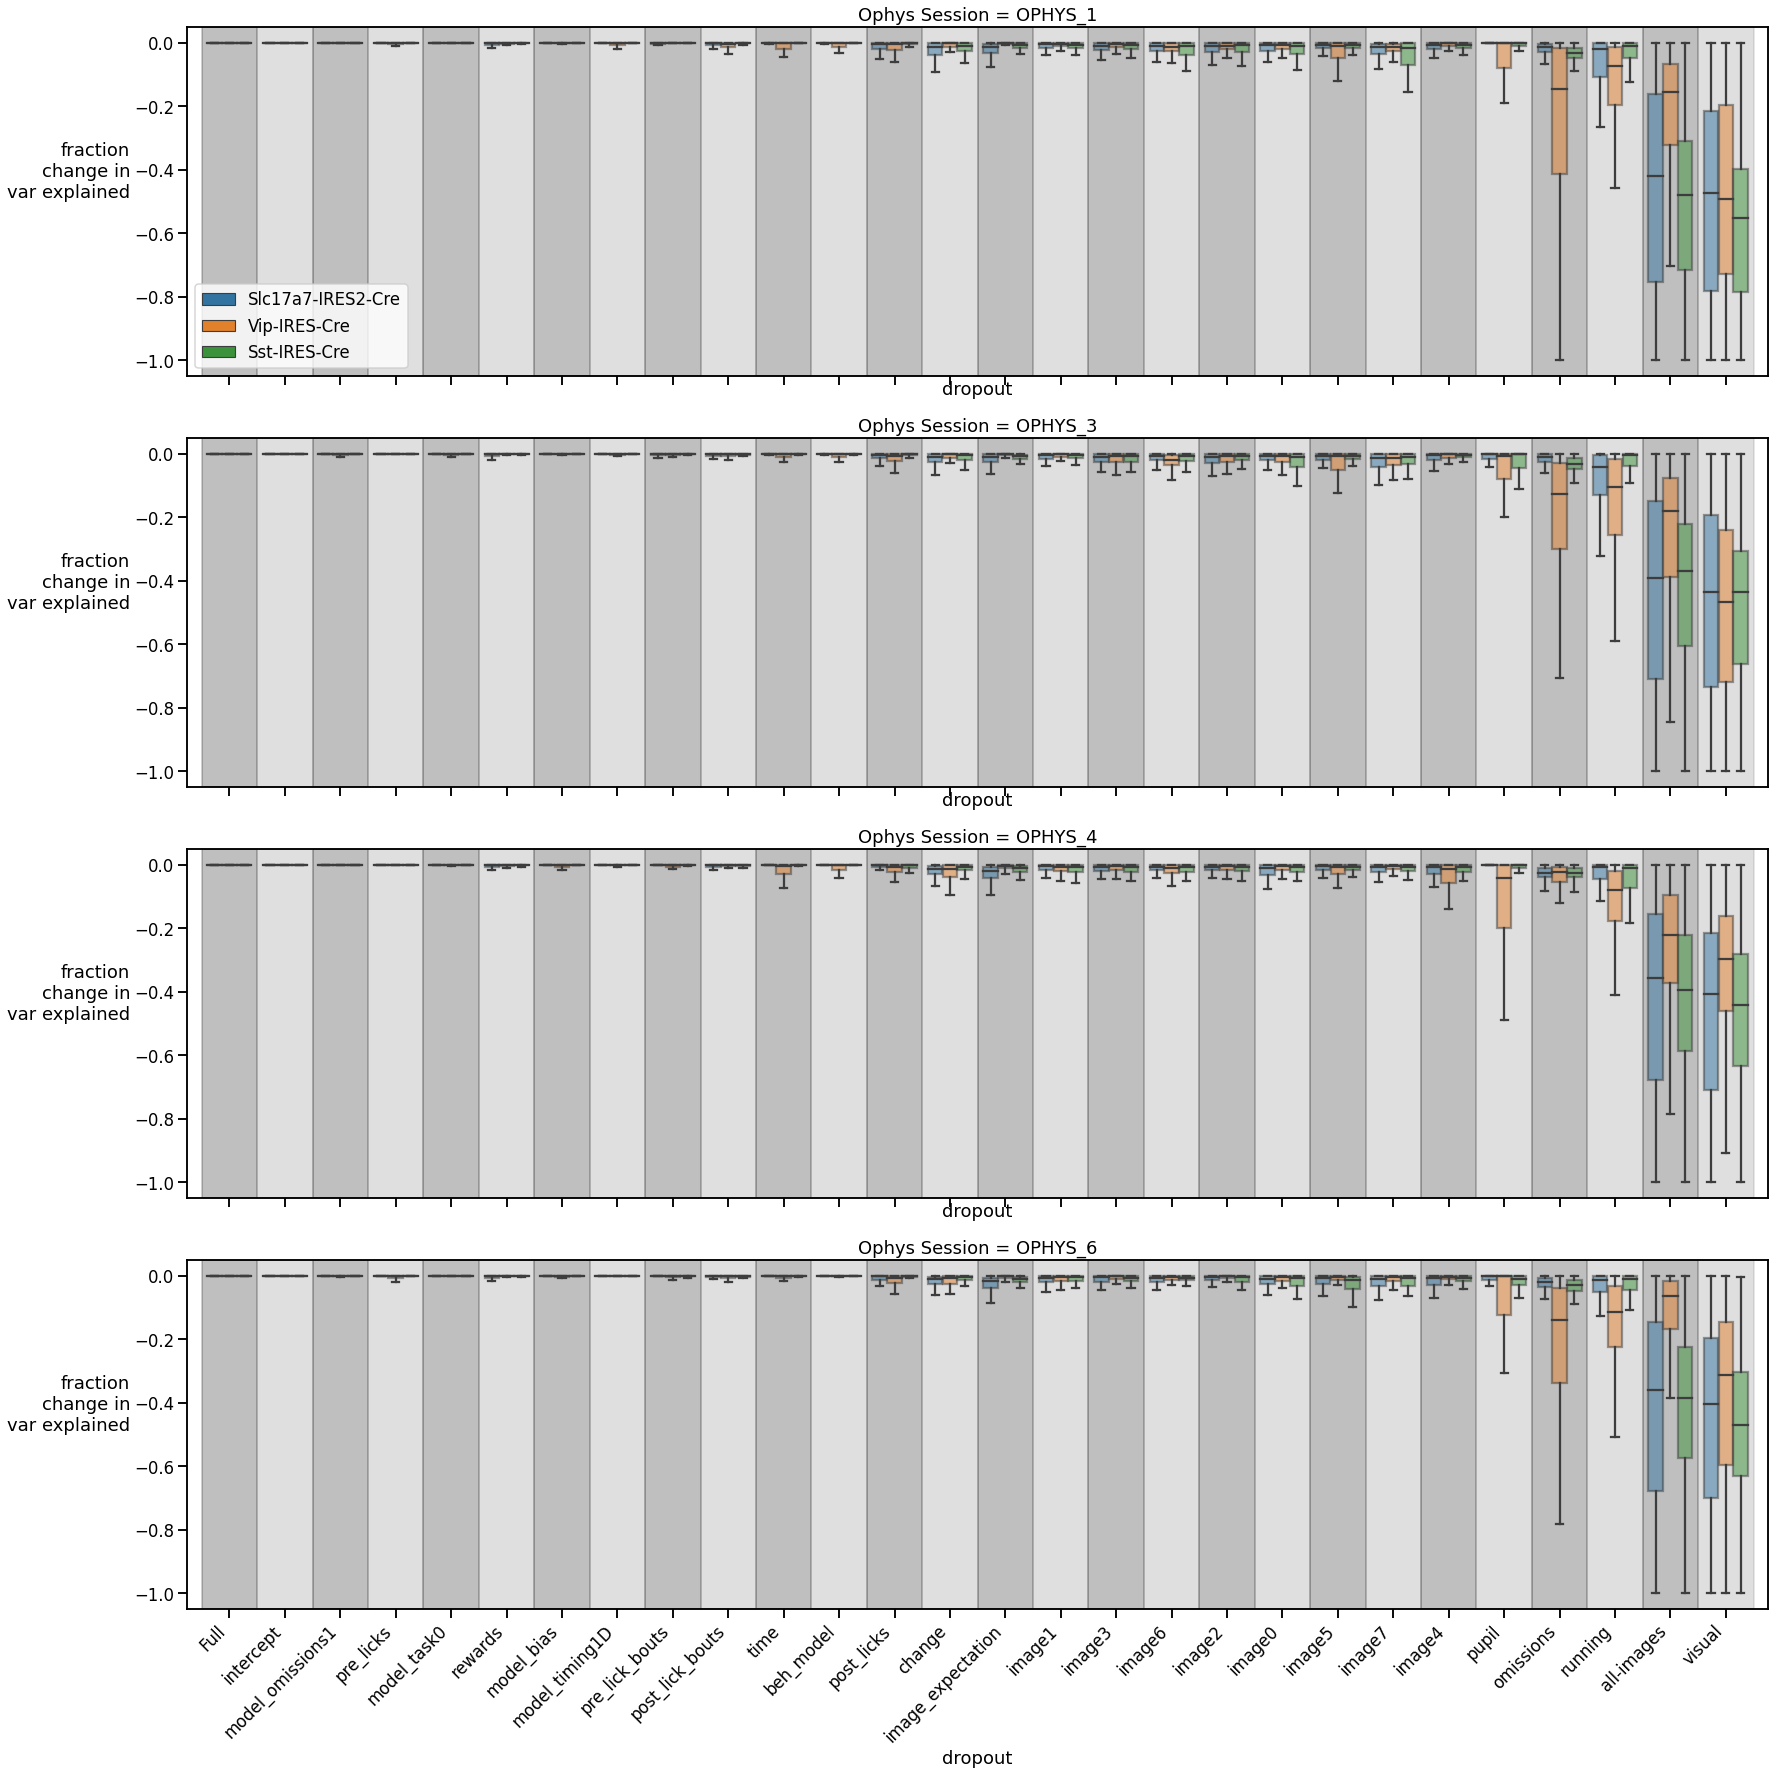

In [46]:
fig,ax=plt.subplots(4,1,figsize=(25,25),sharex=True)
show_dots = False
colors = ['black','gray']
row = 0
for _,session_prefix in enumerate(np.sort(results_summary['session_prefix'].unique())):
    data_to_plot = results_summary.query('session_prefix == @session_prefix and dropout not in @kernels_to_exclude and above_CV_threshold')
    bp = sns.boxplot(
        data = data_to_plot,
        x = 'dropout',
        y = 'clipped_fraction_change_negative_only',
        order=fraction_change_order_negative_only_limited,
        hue='cre_line',
        hue_order=genotype_order,
        ax=ax[row],
        fliersize=0,
        boxprops=dict(alpha=.5)
    )

    if show_dots:
        sp = sns.stripplot(
            data = data_to_plot,
            x = 'dropout',
            y = 'clipped_fraction_change_negative_only',
            order=fraction_change_order_negative_only_limited,
            hue='cre_line',
            hue_order=genotype_order,
            ax=ax[row],
            dodge=True,
            alpha=0.2
        )
#         sp.legend(loc='lower left')
    bp.set_xticklabels(labels=fraction_change_order_negative_only_limited, rotation=45,ha='right')
    ax[row].set_title('Ophys Session = {}'.format(session_prefix))
    ax[row].set_ylabel('fraction\nchange in\nvar explained',rotation=0,ha='right')

    if row != 0:
        bp.legend_.remove()
    else:
        bp.legend(loc='lower left')
        
    for i in range(len(data_to_plot['dropout'].unique())):
        ax[row].axvspan(i-0.5,i+0.5,color=colors[i%2],alpha=0.25, zorder=-np.inf)
    row += 1
    


fig.tight_layout()